https://ei.haas.berkeley.edu/research/papers/WP279.pdf

http://blogs.berkeley.edu/2017/05/08/evidence-of-a-decline-in-electricity-use-by-u-s-households/

# Import Packages

In [45]:
# import local script
import sys
sys.path.insert(0, '/home/john/jupyter_blog/jupyter_blog/scripts')

import numpy as np
import pandas as pd
import statsmodels.api as sm
import eiapi as epi
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from fbprophet import Prophet
%matplotlib inline
plt.style.use('bmh')

# Import Data

In [2]:
# can be obtained from EIA here: http://www.eia.gov/opendata/register.php
api_key = '5F4109570C68FDE20F42C25F5152D879'
# start and end dates for beginning and end of time series
start = '2001-01-01 01:00:00'
end = '2016-12-31 23:00:00'
# must specify that frequency is hourly 'H' for datetime conversion
freq = 'A'

# full list of available series is here: http://www.eia.gov/opendata/qb.php?category=2122628
keys = ['ELEC.SALES.WA-RES.M', 'SEDS.TPOPP.WA.A']

# create dict of GetSeriesRange objects from series list
series_dict = {key: epi.GetSeries(api_key=api_key, series_id=key, 
                                    start=start, end=end, freq=freq) for key in keys}

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): api.eia.gov
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): api.eia.gov


# Print Returned Data

In [3]:
for key in series_dict:
    print('Series Name {} \n Units: {} \n Key {}'.format(series_dict[key].data.series[0]['name'], 
                             series_dict[key].data.series[0]['units'], key))

Series Name Resident population including Armed Forces, Washington 
 Units: Thousand 
 Key SEDS.TPOPP.WA.A
Series Name Retail sales of electricity : Washington : residential : monthly 
 Units: million kilowatthours 
 Key ELEC.SALES.WA-RES.M


# Graph Series

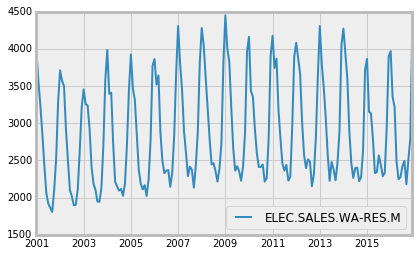

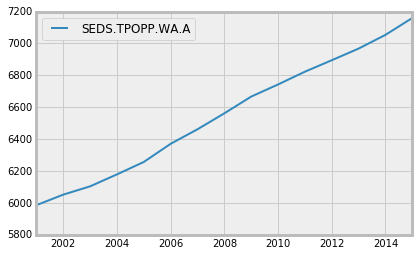

In [56]:
# create new data frames
wa_sales = series_dict['ELEC.SALES.WA-RES.M'].data.df.sort_index()
wa_pop = series_dict['SEDS.TPOPP.WA.A'].data.df.sort_index()

# convert index to datetime
wa_sales.index = pd.to_datetime(wa_sales.index)
wa_pop.index = pd.to_datetime(wa_pop.index)

# plot total washington residential electricity sales and population
wa_sales.plot()
wa_pop.plot()

# Plot Per Capita Washington Consumption

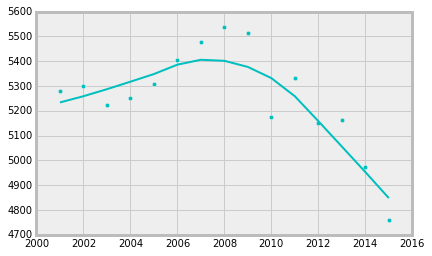

In [57]:
# Group sales data to annual, merge with population series and create per capita
wa_sales_annual = wa_sales.groupby(pd.Grouper(freq='A'))['ELEC.SALES.WA-RES.M'].agg(['sum'])
wa_sales_annual['year'] = wa_sales_annual.index.to_period('A')
wa_pop['year'] = wa_pop.index.to_period('A')
wa_merged = pd.merge(wa_sales_annual, wa_pop, on='year')
wa_merged['year'] = wa_merged['year'].astype(str).astype(int)
wa_merged['per_capita'] = wa_merged['sum']*1000/wa_merged['SEDS.TPOPP.WA.A']

# Create Loess of Per Capita
wa_merged['per_capita_loess'] = sm.nonparametric.lowess(
    wa_merged['per_capita'], wa_merged['year'], return_sorted=False)

# Graph Smoothed Electricity Sales Per Capita
plt.scatter(wa_merged['year'], wa_merged['per_capita'], c='c')
plt.plot(wa_merged['year'], wa_merged['per_capita_loess'], c='c')
plt.show()

# Deseasonalize Electricity Sales Data

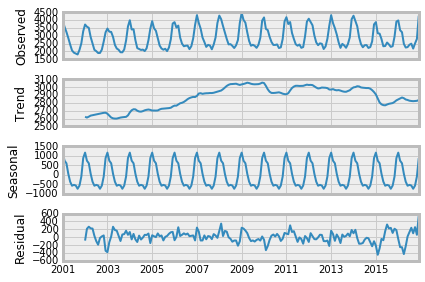

In [54]:
# Run seasonal decomposition and plot
wa_sales_decompose = sm.tsa.seasonal_decompose(wa_sales, two_sided=False)
decmpose_plot = wa_sales_decompose.plot()

# Extract deseasonlized trend and aggregate to annual frequency

In [9]:
# Create a filtered series : trend 
wa_sales_tsa = wa_sales_decompose.trend
# Group deaseasonalized sales trend by year
wa_sales_tsa_annual = wa_sales_tsa.groupby(
    pd.Grouper(freq='A'))['ELEC.SALES.WA-RES.M'].agg(['sum','count'])
# Drop years where there isn't 12 months of filtered data
wa_sales_tsa_annual = wa_sales_tsa_annual[wa_sales_tsa_annual['count']==12]
wa_sales_tsa_annual.drop('count', axis=1, inplace=True)

# Join TSA Detrended Consumption and Population Data

In [11]:
# create annual key and merge sales and population dfs
wa_sales_tsa_annual['year'] = wa_sales_tsa_annual.index.to_period('A')
wa_tsa_merged = pd.merge(wa_sales_tsa_annual, wa_pop, on='year')
# coerce year datetime to int
wa_tsa_merged['year'] = wa_tsa_merged['year'].astype(str).astype(int)
# create per_capita sales variable
wa_tsa_merged['per_capita'] = wa_tsa_merged['sum']*1000 / wa_tsa_merged['SEDS.TPOPP.WA.A']
# create loess smoother on per_capita sales
wa_tsa_merged['per_capita_loess'] = sm.nonparametric.lowess(
    wa_tsa_merged['per_capita'], wa_tsa_merged['year'], return_sorted=False)

# Plot deseasonalized per capita consumption

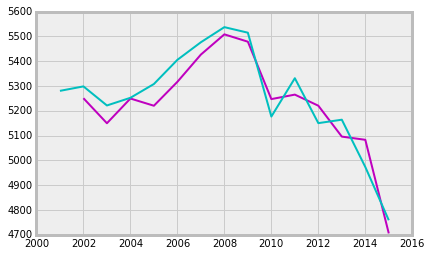

In [58]:
plt.plot(wa_tsa_merged['year'], wa_tsa_merged['per_capita'], c='m')
plt.plot(wa_per_capita['year'], wa_per_capita['per_capita'], c='c')
plt.show()

# Deseasonalize Using Facebook Prophet

In [13]:
# Prophet requires independent (y) and Datetime (ds) inputs vars in dataframe
df = pd.DataFrame(columns=['y','ds'])
df['ds'] = wa_sales.index
df['y'] = wa_sales['ELEC.SALES.WA-RES.M'].values

# fit the prophet model
m = Prophet().fit(df)
future = m.make_future_dataframe(periods=0, freq='M')
fcst = m.predict(future)
fcst.index = fcst['ds'].values

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Extract deseasonalized trend and aggregate to annual frequency

In [16]:
# group deaseasonalized sales trend by year
wa_sales_proph = fcst.groupby(pd.Grouper(freq='A'))['trend'].agg(['sum','count'])
# unlike tsa.seasonal decompose there are no obs dropped from historical time series
# but we'll apply the filter anyways and drop the count variable
wa_sales_proph_annual = wa_sales_proph[wa_sales_proph['count']==12]
wa_sales_proph_annual.drop('count', axis=1, inplace=True)

# Join Prophet Detrended Consumption and Population Data

In [24]:
# create annual key and merge sales and population dfs
wa_sales_proph_annual['year'] = wa_sales_proph_annual.index.to_period('A')
wa_proph_merged = pd.merge(wa_sales_proph_annual, wa_pop, on='year')
# coerce year datetime to int
wa_proph_merged['year'] = wa_proph_merged['year'].astype(str).astype(int)
# create per_capita sales variable
wa_proph_merged['per_capita'] = (wa_proph_merged['sum']*1000 / 
                                   wa_proph_merged['SEDS.TPOPP.WA.A'])

# Plot prophet per capita vs tsa per capita

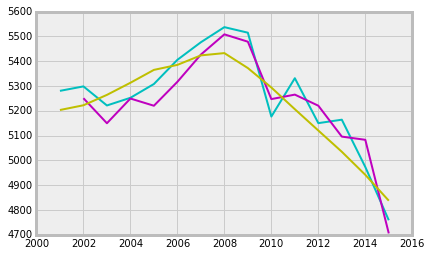

In [64]:
plt.plot(wa_merged['year'], wa_merged['per_capita'], c='c')
plt.plot(wa_tsa_merged['year'], wa_tsa_merged['per_capita'], c='m')
plt.plot(wa_proph_merged['year'], wa_proph_merged['per_capita'], c='y')
plt.show()